In [1]:
import numpy as np
import pandas as pd

from itertools import chain
from matplotlib import pyplot as plt

from parse_input_file import parse_file
from create_feature_dfs import compose_signals_df, create_initial_input
from LeastSquaresMethod import LeastSquaresMethod
from RecursiveLeastSquaresMethod import RecursiveLeastSquaresMethod
from metrics import compose_all_metrics
from ploting_utils import plot_one_model_metric, plot_two_models_metric

In [2]:
READ_FROM_FILE = False

In [7]:
if READ_FROM_FILE:
    parsing_result = parse_file('Test+')
    
    a_coefs = [parsing_result['out_weights'][i] for i in parsing_result['out_weights'].keys()]
    b_coefs = [parsing_result['manage_weights'][i] for i in parsing_result['manage_weights'].keys()]
else:
    a_coefs = [0,0.15,-0.33,0.25]
    b_coefs = [1,0.3,0.7,0.]

    parsing_result = create_initial_input(a_coefs, b_coefs, uniform_low=0, uniform_high=100, time_series_shape=100, noise_std=1)

In [8]:
features_dfs = compose_signals_df(parsing_result)

features_dfs.head()

,y(k),y(k-1),y(k-2),y(k-3),v(k),v(k-1),v(k-2),v(k-3)
0,51.144788,5.817490,69.972183,86.126046,48.869760,7.022462,71.827350,84.106041
1,43.682070,51.144788,5.817490,69.972183,67.198567,48.869760,7.022462,71.827350
2,46.123285,43.682070,51.144788,5.817490,95.444063,67.198567,48.869760,7.022462
3,80.978767,46.123285,43.682070,51.144788,14.990451,95.444063,67.198567,48.869760
4,79.253105,80.978767,46.123285,43.682070,59.400139,14.990451,95.444063,67.198567


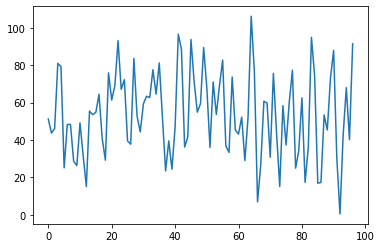

In [9]:
features_dfs['''y(k)'''].plot()

# Moving average

In [30]:
def moving_average(a, n=3, weights=None):
    
    if weights == 'exp':
        weights = np.exp(-np.arange(start=0,stop=n))
    if weights == 'exp_smoothed':
        weights = np.arange(start=0,stop=n)**(1 - 2/(n+1))
    else:
        weights = np.ones(n)
        
    print(weights)
        
    a = np.array(a)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    print(ret[n - 1:])
    print(ret[n-1:].shape[0]/n)
    return ret[n - 1:]@weights / weights.sum()

In [31]:
moving_avarege_result = moving_average(features_dfs['''y(k)'''], n=5)

[1. 1. 1. 1. 1.]
[301.18201484 275.10779873 279.72943765 281.88782513 229.50487936
 176.56362328 200.60805038 183.8860424  150.68477471 177.50809044
 204.72662921 210.3801672  243.22470115 269.05652081 242.8347248
 265.21589209 271.78436463 276.41562478 328.58873741 366.46865163
 362.81130897 340.9118016  309.59925543 300.17281382 285.79430202
 257.82821757 277.77330866 303.40569079 282.42681808 307.28810676
 327.51978907 349.34824942 338.13585406 298.84588991 260.7695939
 220.62341849 186.27851871 230.72399269 295.76133737 292.4865001
 309.7209374  356.60713815 331.19187325 297.61823952 320.78896857
 368.65693976 342.89924717 307.71815144 323.90316828 318.15953528
 297.96213504 312.72625737 313.52774106 275.82640418 295.86049403
 271.86791001 232.25259825 247.65561433 243.27035368 221.46372373
 282.36443516 315.83184403 270.49571766 268.04127361 276.90327175
 230.44140374 184.56591072 253.3116259  270.23564744 224.61155237
 223.21723205 229.76288068 214.30621231 248.22228394 258.02904

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 93)

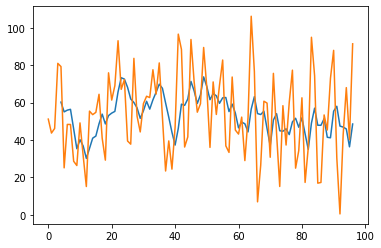

In [19]:
plt.plot(range(4,features_dfs.shape[0]),moving_avarege_result)
plt.plot(features_dfs['''y(k)'''])
plt.show()

# Least Square Method

In [ ]:
best_ls_method = LeastSquaresMethod(biased=True)

In [ ]:
best_ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                   y=np.array(features_dfs['''y(k)''']))

In [ ]:
ls_pred = best_ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''])))

In [ ]:
features_dfs['lsm_pred'] = ls_pred
features_dfs[['''y(k)''','lsm_pred']].plot();
features_dfs.drop(columns='lsm_pred', inplace=True)

In [ ]:
compose_all_metrics(features_dfs['''y(k)'''], ls_pred, best_ls_method.coef_matrix.shape[0])

## Different LS Models

In [ ]:
ls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        ls_method = LeastSquaresMethod(biased=True)
        ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                      y=np.array(features_dfs['''y(k)''']))
        ls_pred = ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], ls_pred, ls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        ls_models.append(temp_results)
        

In [ ]:
plot_one_model_metric(ls_models, 'rmse')

In [ ]:
plot_one_model_metric(ls_models, 'determination_coef')

In [ ]:
plot_one_model_metric(ls_models, 'akke_coef')

# Recursive Least Square Method

In [ ]:
best_rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - 1, 
                                              biased=True)

In [ ]:
rls_pred, rls_coefs = best_rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                                                  y=np.array(features_dfs['''y(k)''']))

In [ ]:
features_dfs['rlsm_pred'] = rls_pred
features_dfs[['''y(k)''','rlsm_pred']].plot();
features_dfs.drop(columns='rlsm_pred', inplace=True)

In [ ]:
compose_all_metrics(features_dfs['''y(k)'''], rls_pred, best_rls_method.coef_matrix.shape[0])

In [ ]:
rls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - len(coefs_to_ignore) - 1, 
                                                 biased=True)
        rls_pred, _ = rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                                                     y=np.array(features_dfs['''y(k)''']))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], rls_pred, rls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        rls_models.append(temp_results)

In [ ]:
plot_one_model_metric(rls_models, 'rmse')

In [ ]:
plot_one_model_metric(rls_models, 'determination_coef')

In [ ]:
plot_one_model_metric(rls_models, 'akke_coef')

# Compare models

## Metrics

In [ ]:
models_dict = {'ls_method':ls_models, 'rls_method':rls_models}

In [ ]:
plot_two_models_metric(models_dict, 'rmse')

In [ ]:
plot_two_models_metric(models_dict, 'determination_coef')

In [ ]:
plot_two_models_metric(models_dict, 'akke_coef')

## Coefficients

In [ ]:
plt.rcParams["figure.figsize"] = (20,20)

fig, axs = plt.subplots(2, 4)

for i in range(len(a_coefs)):
    axs[0,i].set_title('''a({})'''.format(i))
    axs[0,i].plot(np.array(rls_coefs)[:,i])
    axs[0,i].plot([a_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].plot([best_ls_method.coef_matrix[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')
    

for i in range(len(b_coefs)):
    axs[1,i].set_title('''b({})'''.format(i))
    axs[1,i].plot(np.array(rls_coefs)[:,i+len(a_coefs)])
    axs[1,i].plot([b_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[1,i].plot([best_ls_method.coef_matrix[i+len(a_coefs)] for j in range(rls_coefs.shape[0])])
    axs[1,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')

In [ ]:
models_df = dict()
models_df['ls_method'] = pd.DataFrame({k_2: [el[k_2] for el in models_dict['ls_method']] for k_2 in ['name', 'rmse', 'determination_coef', 'akke_coef']})
models_df['rls_method'] = pd.DataFrame({k_2: [el[k_2] for el in models_dict['rls_method']] for k_2 in ['rmse', 'determination_coef', 'akke_coef']})

pd.concat(models_df, axis=1)